In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
%matplotlib inline
import seaborn as sns
import math
import ast
import progressbar
import os
import networkx as nx

# import umap
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from matplotlib.colors import LinearSegmentedColormap
import statsmodels.formula.api as smf

## Import the data
 First we load all the datasets that we will be using.

In [30]:
# Data paths (folder and path are seperated in order to easily check if the pickle version of the file exists)
characters_metadata_path    = {'path':'./data/MovieSummaries/character.metadata',   'extension':'.tsv'}
movies_metadata_path        = {'path':'./data/MovieSummaries/movie.metadata',       'extension':'.tsv'}
movie_summaries_path        = {'path':'./data/MovieSummaries/plot_summaries',       'extension':'.txt'}

imdb_names_path         = {'path':'./data/imdb/imdb_names',         'extension':'.tsv'} 
imdb_principals_path    = {'path':'./data/imdb/imdb_principals',    'extension':'.tsv'}
imdb_ratings_path       = {'path':'./data/imdb/imdb_ratings',       'extension':'.tsv'} 
imdb_titles_path        = {'path':'./data/imdb/imdb_titles',        'extension':'.tsv'}

kaggle_awards_path = {'path':'./data/kaggle/the_oscar_award', 'extension':'.csv'}

# Column names for the MCU datasets (since they are not provided in the datasets themselves)
colnames_charac = ['Wikipedia movie ID', 'Freebase movie ID', 'Movie release date', 'Character name', 'Actor date of birth', 'Actor gender', 'Actor height', 'Actor ethnicity', 'Actor name', 'Actor age', 'Freebase character/actor map ID', 'Freebase character ID', 'Freebase actor ID']
colnames_movie = ['Wikipedia movie ID', 'Freebase movie ID', 'Movie name', 'Movie release date', 'Movie box office revenue', 'Movie runtime', 'Movie languages', 'Movie countries', 'Movie genres'] 
colnames_plot = ['Wikipedia movie ID', 'Plot'] 

For efficiency, we use pickle in order to speed up the loading process.

In [3]:
pkl_extension = ".pkl"

# Load the dataset given the data dict containing the path and the file extension and check if 
# the pickle exists and either load it or create it and return the dataframe
def load_and_pickle(data_dict, default_load):
    if os.path.exists(data_dict['path'] + pkl_extension):
        print('Pickle file found for {} .'.format(data_dict['path']))
        return pd.read_pickle(data_dict['path'] + pkl_extension)
    else:
        print('No pickle found for {}. Creating it...'.format(data_dict['path']), end='')
        df = default_load(''.join(data_dict.values()))
        df.to_pickle(data_dict['path'] + pkl_extension)
        print('Done.')
        return df

In [32]:
# N.B takes ~2 minute without pickles, ~20 seconds with pickles

# Load datasets 
meta_charac_raw = load_and_pickle(characters_metadata_path, lambda path: pd.read_csv(path, names=colnames_charac, sep='\t'))
meta_movie_raw  = load_and_pickle(movies_metadata_path, lambda path: pd.read_csv(path, names=colnames_movie, sep='\t'))
plot            = load_and_pickle(movie_summaries_path, lambda path: pd.read_csv(path, names=colnames_plot, sep='\t'))

# Load IMDb datasets
imdb_names      = load_and_pickle(imdb_names_path, lambda path: pd.read_csv(path, header=0, sep='\t'))
imdb_principals = load_and_pickle(imdb_principals_path, lambda path: pd.read_csv(path, header=0, sep='\t'))
imdb_raitings   = load_and_pickle(imdb_ratings_path, lambda path: pd.read_csv(path, header=0 , sep='\t'))
imdb_title_raw  = load_and_pickle(imdb_titles_path, lambda path: pd.read_csv(path, header=0, sep='\t', dtype= 'string'))

# Load kaggle awards dataset
kaggle_awards_raw = load_and_pickle(kaggle_awards_path, lambda path: pd.read_csv(path, header=0))

Pickle file found for ./data/MovieSummaries/character.metadata .
Pickle file found for ./data/MovieSummaries/movie.metadata .
Pickle file found for ./data/MovieSummaries/plot_summaries .
Pickle file found for ./data/imdb/imdb_names .


Pickle file found for ./data/imdb/imdb_principals .
Pickle file found for ./data/imdb/imdb_ratings .
Pickle file found for ./data/imdb/imdb_titles .
Pickle file found for ./data/kaggle/the_oscar_award .


## Shaping the datasets

Here the goal is simply to make sure that the columns in datasets have correct types and to remove columns that we won't be needing so as not to clutter our analysis

In [33]:
# Select columns of the original dataset
meta_charac = meta_charac_raw.drop(['Freebase movie ID', 'Freebase character/actor map ID', 'Freebase character ID', 'Freebase actor ID'], axis=1).copy()
meta_movie = meta_movie_raw.drop(['Freebase movie ID', 'Movie languages', 'Movie countries'], axis=1).copy()

# Select colomns of IMDb datasets
imdb_title = imdb_title_raw.drop(['endYear', 'runtimeMinutes'], axis=1).copy()

# Select columns of kaggle awards dataset
kaggle_awards = kaggle_awards_raw.drop(['category'], axis = 1).copy()

In [34]:
# For consistency we remove day and month from actor date of birth and movie release date.
meta_movie["Movie release date"] = meta_movie["Movie release date"].apply(lambda x: x.split("-")[0] if type(x) == str else x).astype(pd.Int64Dtype())
meta_charac["Movie release date"] = meta_charac["Movie release date"].apply(lambda x: x.split("-")[0] if type(x) == str else x).astype(pd.Int64Dtype())
meta_charac["Actor date of birth"] = meta_charac["Actor date of birth"].apply(lambda x: x.split("-")[0] if type(x) == str else x).astype(pd.Int64Dtype())

# Turn movie genres into dictionary
meta_movie['Movie genres'] = meta_movie['Movie genres'].apply(ast.literal_eval)

In [35]:
print('--- Meta Movie ---')
print(meta_movie.dtypes.to_string())
print('--- Meta Character ---')
print(meta_charac.dtypes.to_string())
print('--- Plot ---')
print(plot.dtypes.to_string())

--- Meta Movie ---
Wikipedia movie ID            int64
Movie name                   object
Movie release date            Int64
Movie box office revenue    float64
Movie runtime               float64
Movie genres                 object
--- Meta Character ---
Wikipedia movie ID       int64
Movie release date       Int64
Character name          object
Actor date of birth      Int64
Actor gender            object
Actor height           float64
Actor ethnicity         object
Actor name              object
Actor age              float64
--- Plot ---
Wikipedia movie ID     int64
Plot                  object


We will now have a look at the NaNs in the resulting datasets

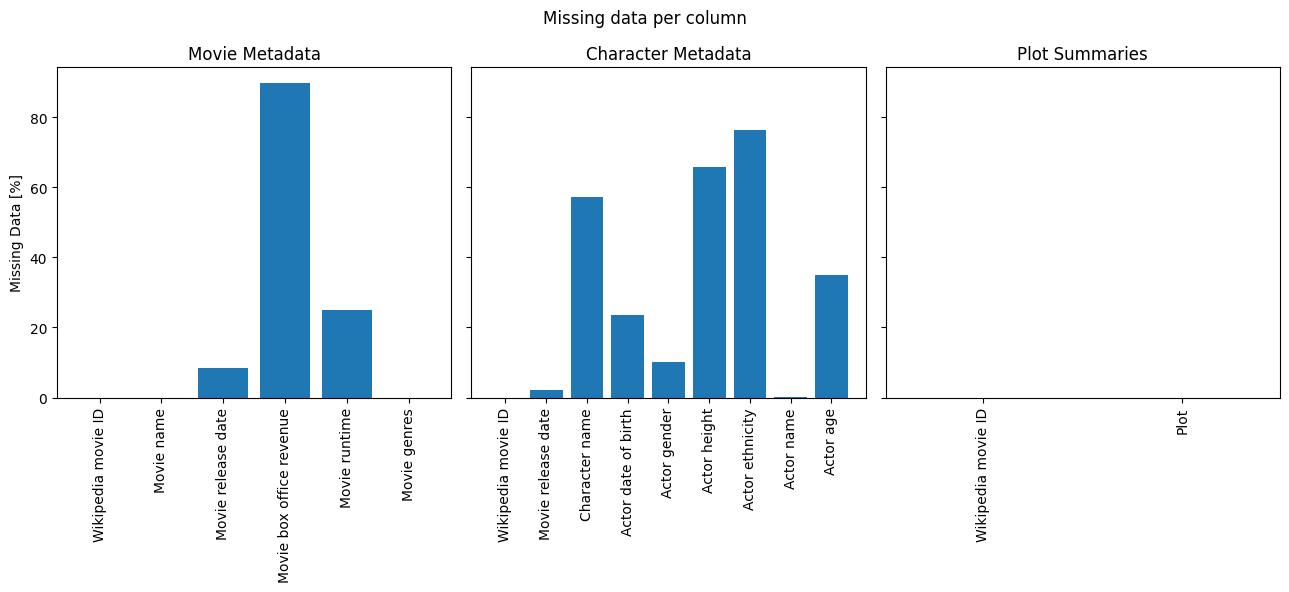

--- Dataset shapes ---
Movies metadata: (81741, 6)
Character metadata: (81741, 6)
Plot summaries: (42303, 2)


In [36]:
# Calculating missing data
missing_movie = meta_movie.isnull().sum() * 100 / len(meta_movie)
missing_char = meta_charac.isnull().sum() * 100 / len(meta_charac)
missing_plot = plot.isnull().sum() * 100 / len(plot)

# Plotting
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(13, 6), sharey=True)
fig.suptitle('Missing data per column')

# Set axis labels and titles
ax1.set(ylabel= 'Missing Data [%]')
ax1.bar(missing_movie.index, missing_movie.values)
ax1.tick_params(axis='x', labelrotation = 90)
ax1.set_title("Movie Metadata")
ax2.bar(missing_char.index, missing_char.values)
ax2.tick_params(axis='x', labelrotation = 90)
ax2.set_title("Character Metadata")
ax3.bar(missing_plot.index, missing_plot.values)
ax3.tick_params(axis='x', labelrotation = 90)
ax3.set_title("Plot Summaries")
plt.tight_layout()
plt.show()

print("--- Dataset shapes ---")
print("Movies metadata: {}" .format(meta_movie.shape))
print("Character metadata: {}" .format(meta_movie.shape))
print("Plot summaries: {}" .format(plot.shape))

*Observation:* From this initial analysis, it's evident that there is a significant amount of missing data.

*Action:* To address this, we've decided to drop certain actor features, specifically `character name` ,  `actor height`, `actor ethnicity`, and `actor age`, recognizing the high incidence of missing values in these columns. We are keeping `Movie box office revenue` but acknowledge the presence of missing values, and we plan to incorporate it into our analysis only if we have the resources and time to enrich our database.


In [37]:
charac = meta_charac.drop(columns=['Character name','Actor ethnicity', 'Actor height', 'Actor age'])

# 1. Dataframe 1: movies
## 1.1 Adding IMDb scores
We will start by adding the IMDb scores to the movie dataset, we want every movie in our dataset to have a rating, so we will use an **inner merge** (default) on the **title** and **year**. 

But first will need to have a look at the IMDb dataset.

In [38]:
# Display a sample of 5 rows from the 'imdb_title' DataFrame.
print("     ----- Title data sample -----")
display(imdb_title.sample(5))

# Display a sample of 5 rows from the 'imdb_ratings' DataFrame.
print("     ----- Raiting data overview -----")
display(imdb_raitings.sample(5))

     ----- Title data sample -----


,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,genres
804731,tt0831022,tvEpisode,Sakura and Her True Feeling,Sakura and Her True Feeling,0,2000,"Action,Adventure,Animation"
10042172,tt9369310,tvSeries,Tales from the Tomb,Tales from the Tomb,0,1974,"Comedy,Horror,Sci-Fi"
4258934,tt16071736,tvEpisode,20. juni 2019 kl. 22:55,20. juni 2019 kl. 22:55,0,2019,News
2320379,tt12445816,tvEpisode,Live Stream - VHS Tape Contents 6,Live Stream - VHS Tape Contents 6,0,\N,"Horror,Short"
5361692,tt21083226,tvEpisode,Episode #1.512,Episode #1.512,0,2022,Drama


     ----- Raiting data overview -----


,tconst,averageRating,numVotes
134410,tt0206124,7.3,12
298288,tt0573943,7.4,103
65239,tt0090647,6.8,438
1245164,tt6955920,8.0,27
503584,tt10921922,10.0,16


In [39]:
# keep only movies
imdb_movieTitle = imdb_title[imdb_title['titleType'] == 'movie'].copy() 
# remove Nan years
imdb_movieTitle = imdb_movieTitle[imdb_movieTitle['startYear'] != '\\N'].copy() 
# turn year to int
imdb_movieTitle['startYear'] = imdb_movieTitle['startYear'].astype(int) 
# rename actor ID for ease of use
imdb_names.rename(columns={'nconst':'IMDb_actor_ID'}, inplace=True) 

# Merging the IMDb and CMU datasets
movies = meta_movie\
            .merge(imdb_movieTitle[['originalTitle','startYear','tconst']], left_on= ['Movie name', 'Movie release date'], right_on= ['originalTitle','startYear'], how= 'inner')\
            .merge(imdb_raitings, how ='inner')
movies.rename(columns={"tconst":"IMDb_ID"}, inplace= True) #rename IMDb ID for ease of use

print("--- Movie dataset size ---")
print(movies.shape)

--- Movie dataset size ---
(35612, 11)


The merge will only consider movies whose titles are an exact match which might not always be the case due to different capitalization of different coma placement. Thus the 35'000 rows that we get is a lower bound of the amount of rows that we could get if we used a more clever matching technique. For instance we could mitigate the problem of capitals matching by putting all strings to lower case.

## 1.2 Filtering
We are proceeding to filter outliers in the dataset. The goal is to identify and exclude any data points that deviate significantly from the general pattern, ensuring that our analysis is not influenced by extreme values.

In [40]:
# Save an unfieltered version of movies
movies_uf = movies.copy()

# We are removing outliers in the film duration to standardize our data
max_movie_runtime = 200 # [minutes]
min_movie_runtime = 40  # [minutes]
movies = movies.query('`Movie runtime` <= @max_movie_runtime and `Movie runtime` >= @min_movie_runtime').copy()

# To ensure enough films are available per year, we are removing the older and newer years
max_movie_year = 2012
min_movie_year = 1930
movies = movies.query('`Movie release date` <= @max_movie_year and `Movie release date` >= @min_movie_year').copy()

# We are removing films with too few votes
min_votes = 50
movies = movies.query('`numVotes` >= @min_votes').copy()

Let's also drop all duplicates in the dataset, and replace all "\\N" values with NaNs. 

In [41]:
movies.drop_duplicates(subset=['IMDb_ID'], inplace=True)
movies.replace('\\N', pd.NA, inplace=True)

In [42]:
# Display a random sample of 5 rows from the 'movies' DataFrame.
movies.sample(5)

,Wikipedia movie ID,Movie name,Movie release date,Movie box office revenue,Movie runtime,Movie genres,originalTitle,startYear,IMDb_ID,averageRating,numVotes
29394,947419,Funny Lady,1975,4.005590e+07,135.0,"{'/m/06cvj': 'Romantic comedy', '/m/04t36': 'M...",Funny Lady,1975,tt0073026,6.2,5837
6393,15351941,Genova,2008,NaN,94.0,"{'/m/03npn': 'Horror', '/m/0219x_': 'Indie', '...",Genova,2008,tt0791303,6.0,6719
4203,14482638,Alice in Wonderland,2010,1.024300e+09,108.0,"{'/m/01zhp': 'Computer Animation', '/m/0hqxf':...",Alice in Wonderland,2010,tt1014759,6.4,432938
9223,21757558,Paging Emma,1999,NaN,112.0,{'/m/07s9rl0': 'Drama'},Paging Emma,1999,tt0138689,8.1,110
18189,6152265,Thunderball,1965,1.412000e+08,130.0,"{'/m/01jfsb': 'Thriller', '/m/0cq22f9': 'Actio...",Thunderball,1965,tt0059800,6.9,124644


# 2. Dataframe 2 : Actors
## 2.1 Extracting main characters from IMDb 


In [43]:
# Input: 
#   - movies: DataFrame containing movie dataset 
#   - imdb_principals: IMDb dataset with principal actors
#   - top_n: Number of principal actors to extract (default 3) [int]
# Output: 
#   - movie_actors: DataFrame with all actors per film. Columns: IMDb_ID, actor, ordering (corresponds to the significance of actors in films)
def get_top_actors(movies, imdb_principals, top_n=3):
    # Filter the 'imdb_principals' DataFrame to include only rows where the category is 'actor' or 'actress'.
    imdb_principal_actors = imdb_principals.query('category == "actor" | category == "actress"')

    # Further filter the above DataFrame to include only those actors/actresses that appear in the 'movies' DataFrame (matched by 'IMDb_ID')
    # and are within the top 'top_n' ordering. 'ordering' likely refers to the importance or lead level of the actor in the movie.
    imdb_principal_actors_valid = imdb_principal_actors[(imdb_principal_actors["IMDb_ID"].isin(movies["IMDb_ID"].values.tolist())) & 
                                                        (imdb_principal_actors["ordering"] <= top_n)]

    # Initialize an empty list to store movie-actor pairings.
    movie_actors = []

    bar = progressbar.ProgressBar(maxval=len(movies["IMDb_ID"])).start()

    # Iterate over each movie ID in the 'movies' DataFrame.
    for idx, id in enumerate(movies["IMDb_ID"]):
         # For each movie, find corresponding actors from 'imdb_principal_actors_valid' and select 'ordering' and 'IMDb_actor_ID'.
        tmp = imdb_principal_actors_valid.loc[imdb_principal_actors_valid["IMDb_ID"] == id][["ordering", "IMDb_actor_ID"]]

        # Append each actor's information along with the movie ID to the 'movie_actors' list.
        for _, row in tmp.iterrows():
            movie_actors.append([id, row["IMDb_actor_ID"], row["ordering"]])
        bar.update(idx)

    # Convert the 'movie_actors' list into a DataFrame for easier handling and readability.
    movie_actors = pd.DataFrame(movie_actors, columns=['IMDb_ID', 'IMDb_actor_ID', 'ordering'])

    # Return the resulting DataFrame.
    return movie_actors

In [44]:
# takes ~5 mins to run
imdb_principals.rename(columns={'nconst':'IMDb_actor_ID'}, inplace=True)
imdb_principals.rename(columns={'tconst':'IMDb_ID'}, inplace=True)
imdb_principals.drop_duplicates(subset=['IMDb_actor_ID', 'IMDb_ID'], inplace=True)

movie_actors = get_top_actors(movies, imdb_principals)
movie_actors.sample(5)

,IMDb_ID,IMDb_actor_ID,ordering
30053,tt0190984,nm0673837,3
73119,tt0905979,nm0000560,2
53072,tt0089326,nm0769540,2
65938,tt0496408,nm0867588,3
36789,tt0121515,nm0014684,3


## 2.2 Creating a one-to-many relationship
We want a one-to-many relationship between movies and movie_actors, i.e for every movie_actor, there is **exactly** one corresponding movie (no NaNs).

In [45]:
# creation of the DataFrame only with valid actors
movies = movies[movies["IMDb_ID"].isin(movie_actors["IMDb_ID"].unique().tolist())]

## 2.3 Adding information to the dataset
We will now added additional data to the actors dataset

In [46]:
# takes ~10 seconds
# Merge 'movie_actors' with selected columns from 'movies' and 'imdb_names' DataFrames.
actors = movie_actors.merge(movies[['Wikipedia movie ID', 'Movie name', 'Movie release date', 'IMDb_ID']], on='IMDb_ID')
actors = actors.merge(imdb_names[['primaryName', 'IMDb_actor_ID', 'birthYear']], left_on='IMDb_actor_ID', right_on='IMDb_actor_ID')

# Display a sample of 5 rows from the resulting 'actors' DataFrame.
actors.sample(5)

,IMDb_ID,IMDb_actor_ID,ordering,Wikipedia movie ID,Movie name,Movie release date,primaryName,birthYear
71316,tt0098725,nm0527954,3,5584803,Sweetie,1989,Tom Lycos,\N
27802,tt0120856,nm0905357,3,5512355,Tarzan and the Lost City,1998,Steven Waddington,1967
34892,tt0080833,nm0058001,2,18854703,Guyana: Crime of the Century,1979,Gene Barry,1919
40348,tt0119589,nm0730657,2,3864332,Ma 6-T va crack-er,1997,Jean-Marie Robert,1974
41232,tt0127536,nm0000949,1,142461,Elizabeth,1998,Cate Blanchett,1969


## 2.4 Adding Actors' connections

In [47]:
# Create an empty dictionary to store centrality values for each year
centrality_dict = {}

# Loop over unique years
for year in actors['Movie release date'].unique():
    # Filter the DataFrame up to the current year
    current_year_data = actors[actors['Movie release date'] <= year]

    # Create an empty graph for the current year
    B = nx.Graph()

    # Iterate through each row in the data for the current year
    for index, row in current_year_data.iterrows():
        actor_id = row['IMDb_actor_ID']
        movie_id = row['IMDb_ID']

        # Add nodes with the 'bipartite' attribute
        B.add_node(actor_id, bipartite=0)
        B.add_node(movie_id, bipartite=1)

        # Add an edge between the actor and the movie
        B.add_edge(actor_id, movie_id)

    # Project the bipartite graph onto the actor nodes
    actor_nodes = [n for n, d in B.nodes(data=True) if d['bipartite'] == 0]
    actor_graph = nx.bipartite.projected_graph(B, nodes=actor_nodes)

    # Calculate the degree of centrality
    centrality = nx.eigenvector_centrality(actor_graph,  max_iter=600)

    # Add centrality values to the dictionary for the current year
    centrality_dict[year] = centrality.copy()

In [48]:
# Convert the dictionary of centrality values to a DataFrame
centrality_df = pd.DataFrame.from_dict(centrality_dict, orient='columns').stack().to_frame().reset_index()
centrality_df = centrality_df.rename(columns={"level_0": "IMDb_actor_ID", "level_1": "Movie release date", 0:"actor_connections"})

actors = pd.merge(actors,centrality_df, on=["IMDb_actor_ID","Movie release date"], how = "inner")

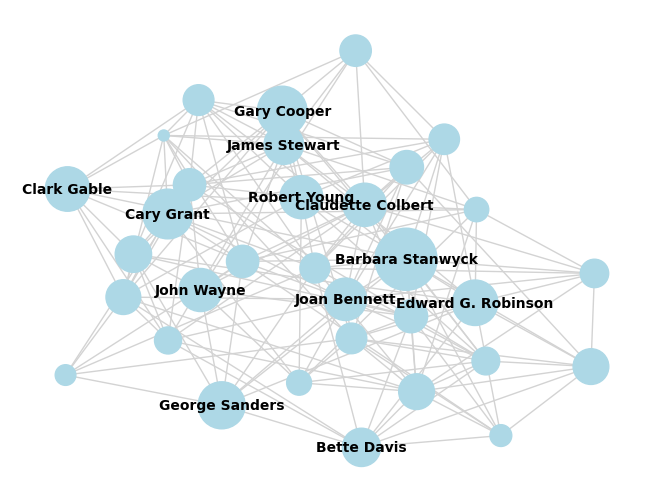

In [49]:
# calculate min and max centrality for node size with thresholds
max_centrality = max(centrality.values())
min_centrality = 0.08
label_threshold = 0.1

# normalise centrality
normalized_centrality = {node: (i_centrality - min_centrality) / (max_centrality - min_centrality) for node, i_centrality in centrality.items()}

# filter nodes
filtered_nodes = [node for node, i_centrality in centrality.items() if i_centrality > min_centrality]
filtered_graph = actor_graph.subgraph(filtered_nodes)

# Add labels only to nodes with centrality higher than the label threshold
high_centrality_labels = {node: actors[actors['IMDb_actor_ID'] == node]['primaryName'].unique()[0] for node, i_centrality in centrality.items() if i_centrality > label_threshold}
pos_filtered = nx.spring_layout(filtered_graph, seed=10, k=3/np.sqrt(filtered_graph.order()), iterations=50)

# plot
nx.draw(filtered_graph, pos_filtered, node_color='lightblue', node_size=[2000 * normalized_centrality[node] for node in filtered_graph.nodes()], font_size=8, edge_color = 'lightgray', alpha=1)
nx.draw_networkx_labels(filtered_graph, pos_filtered, labels=high_centrality_labels, font_size=10, font_color='black', font_weight="bold",)
plt.show()

## 2.4 Adding awards feature

As a specific actor feature, we want to use the number of awards won. To do this we use a kaggle dataset ([link](https://www.kaggle.com/datasets/unanimad/the-oscar-award/code)).


In [50]:
print("kaggle awards shape: " + str(kaggle_awards.shape))
kaggle_awards.sample(5)

kaggle awards shape: (10765, 6)


,year_film,year_ceremony,ceremony,name,film,winner
4660,1968,1969,41,"Franco Solinas, Gillo Pontecorvo",The Battle of Algiers,False
9348,2011,2012,84,"Sarah Green, Bill Pohlad, Dede Gardner and Gra...",The Tree of Life,False
7416,1994,1995,67,"Robert J. Litt, Elliot Tyson, Michael Herbick,...",The Shawshank Redemption,False
430,1936,1937,9,Beulah Bondi,The Gorgeous Hussy,False
9699,2014,2015,87,Argentina,Wild Tales,False


We should filter to keep only movies that are in our dataset

In [51]:
# Keep only actors that are in our actors DataFrame
kaggle_awards = kaggle_awards[kaggle_awards['name'].isin(actors['primaryName'].unique())]
# Keep only movies that are in our movies DataFrame
kaggle_awards = kaggle_awards[kaggle_awards['film'].isin(movies['Movie name'].unique())]
kaggle_awards.sample(5)

,year_film,year_ceremony,ceremony,name,film,winner
4380,1966,1967,39,Richard Brooks,The Professionals,False
1471,1943,1944,16,Gladys Cooper,The Song of Bernadette,False
9024,2009,2010,82,Christopher Plummer,The Last Station,False
8907,2008,2009,81,Sean Penn,Milk,True
5518,1977,1978,50,Maximilian Schell,Julia,False


Let's have a quick scan of the amount of NaNs in this new dataset

In [52]:
kaggle_nans = kaggle_awards.isnull().sum() * 100 / len(kaggle_awards)
display(kaggle_nans)

year_film        0.0
year_ceremony    0.0
ceremony         0.0
name             0.0
film             0.0
winner           0.0
dtype: float64

As we can see, the dataset is NaNs free.

Let's now define a function to get the number of awards won by a given actor up until a given year. For this feature we will only consider the number of awards that the actor won before the movie was released. Using this function we will be able to add a new column in our previous dataframe. 

The function allow counting both the amount of awards won but also the number of nominations

In [53]:
# Input: 
#   - actor_name (str)
#   - year (int)
#   - won (bool) -> Was the nomination won 
# Output:
#   - Number of awards/nominations gained by the actor
def count_awards(actor_name, year, won):
    # We check with the ceremony year because the actor hasn't recieved an award until the ceremony has happened
    if won:
        filtered = kaggle_awards.query("year_ceremony <= @year & name == @actor_name & winner==True")
    else:
        filtered = kaggle_awards.query("year_ceremony <= @year & name == @actor_name")
    
    return len(filtered)

In [54]:
# Takes ~5 mins
# Add 'awards' and 'nominations' columns to the 'actors' DataFrame, calculated using the 'count_awards' function.
actors['awards'] = [count_awards(row['primaryName'], row['Movie release date'], True) for (index, row) in actors.iterrows()]
actors['nominations'] = [count_awards(row['primaryName'], row['Movie release date'], False) for (index, row) in actors.iterrows()]

Let's take a look at Meryl Streep's films as an example to showcase what this function has done

In [55]:
actors.query("primaryName == 'Meryl Streep'").sort_values('Movie release date').head(10)

,IMDb_ID,IMDb_actor_ID,ordering,Wikipedia movie ID,Movie name,Movie release date,primaryName,birthYear,actor_connections,awards,nominations
6293,tt0079417,nm0000658,2,103026,Kramer vs. Kramer,1979,Meryl Streep,1949,0.000448,0,1
6294,tt0079875,nm0000658,3,9090163,The Seduction of Joe Tynan,1979,Meryl Streep,1949,0.000448,0,1
6295,tt0082416,nm0000658,1,3602324,The French Lieutenant's Woman,1981,Meryl Streep,1949,0.000483,1,2
6304,tt0084707,nm0000658,1,4016437,Sophie's Choice,1982,Meryl Streep,1949,0.000856,1,3
6303,tt0084732,nm0000658,2,11612605,Still of the Night,1982,Meryl Streep,1949,0.000856,1,3
6312,tt0086312,nm0000658,1,242548,Silkwood,1983,Meryl Streep,1949,0.001051,2,4
6319,tt0087233,nm0000658,2,6123971,Falling in Love,1984,Meryl Streep,1949,0.001395,2,5
6324,tt0089755,nm0000658,1,89793,Out of Africa,1985,Meryl Streep,1949,0.001895,2,5
6325,tt0089816,nm0000658,1,3066519,Plenty,1985,Meryl Streep,1949,0.001895,2,5
6314,tt0091188,nm0000658,1,2052231,Heartburn,1986,Meryl Streep,1949,0.002273,2,6


## 2.5 Adding the number of movies per actor (total and in said genre)

In [56]:
# Sort the DataFrame by actor ID and movie release date
actors_sorted = actors.sort_values(by=['IMDb_actor_ID', 'Movie release date'])

# Group by actor ID and calculate cumulative count of movies
actors_sorted['movie_count'] = actors_sorted.groupby('IMDb_actor_ID').cumcount() + 1

actors['movie_count'] = actors_sorted['movie_count']


## 2.6 Number of different genres that the actor has played in (diversity)

In [57]:
# Joining the two datasets actors and movies
tmp = actors.join(movies, how='left', lsuffix='_actors', rsuffix='_movies')
# We turn the movie genres dict into a list
tmp["Movie genres"] = tmp["Movie genres"].apply(lambda x: [] if pd.isna(x) else list(x.values()))


In [58]:
# Input:
#   - actor_name (str)
#   - year (int)
# Output:
#   - Number of genres played by the actor until the given year
def count_nb_genres_b4(actor_name, year):
    all_genres_b4 = tmp[(tmp["Movie release date_actors"] <= year) & (tmp["IMDb_actor_ID"] == actor_name)]["Movie genres"].explode().unique()
    return len(all_genres_b4)

actors['genre_diversity'] = [count_nb_genres_b4(row['IMDb_actor_ID'], row['Movie release date_actors']) for (index, row) in tmp.iterrows()]

## 2.8 Adding actor's sex & age at time of movie

In [59]:
# Merging the IMDb and CMU datasets for the character sex
actors = actors.merge(charac[["Actor name",  "Actor gender"]].drop_duplicates(subset=['Actor name']), how='left', left_on='primaryName', right_on='Actor name')
actors["is_male"] = actors["Actor gender"].apply(lambda x : 1 if x == "M" else (0 if x == "F" else np.nan)).astype(pd.Int64Dtype())
actors.drop(columns=["Actor name", "Actor gender"], inplace=True)

In [60]:
# Input:
#   - birth_year (int)
#   - release_year (int)
# Output:
#   - Age of the actor at the release of the movie
def age_at_release(birth_year, release_year):
    if pd.isna(birth_year) or pd.isna(release_year) or birth_year == "\\N" or release_year == "\\N":
        return np.nan
    else:
        return int(release_year) - int(birth_year)

actors["age_at_release"] = [age_at_release(row['birthYear'], row['Movie release date']) for (index, row) in actors.iterrows()]
actors["age_at_release"] = actors["age_at_release"].astype(pd.Int64Dtype())
actors.drop(columns=["birthYear"], inplace=True)

Replacing "\\\N" values with NaNs

In [61]:
actors.replace("\\N", pd.NA, inplace=True)

In [62]:
actors.sample(5)

,IMDb_ID,IMDb_actor_ID,ordering,Wikipedia movie ID,Movie name,Movie release date,primaryName,actor_connections,awards,nominations,movie_count,genre_diversity,is_male,age_at_release
14760,tt0139134,nm0000702,3,93559,Cruel Intentions,1999,Reese Witherspoon,0.000458,0,0,7,21,0,23
43969,tt0844993,nm0659363,1,15968935,Hoodwinked Too! Hood vs. Evil,2011,Hayden Panettiere,0.000480,0,0,4,1,0,22
30364,tt0034241,nm0668361,2,3904503,Sun Valley Serenade,1941,John Payne,0.016521,0,0,4,9,1,29
45014,tt0041982,nm0378209,2,18908881,Train of Events,1949,Gladys Henson,0.000041,0,0,1,1,0,52
28763,tt0064045,nm0001699,3,887164,The Assassination Bureau,1969,Telly Savalas,0.007747,0,1,6,20,1,47


# 3 General Data Analysis 
Let's take a look at what our final DataFrames look like
## 3.1 Dataframe 1: Movies

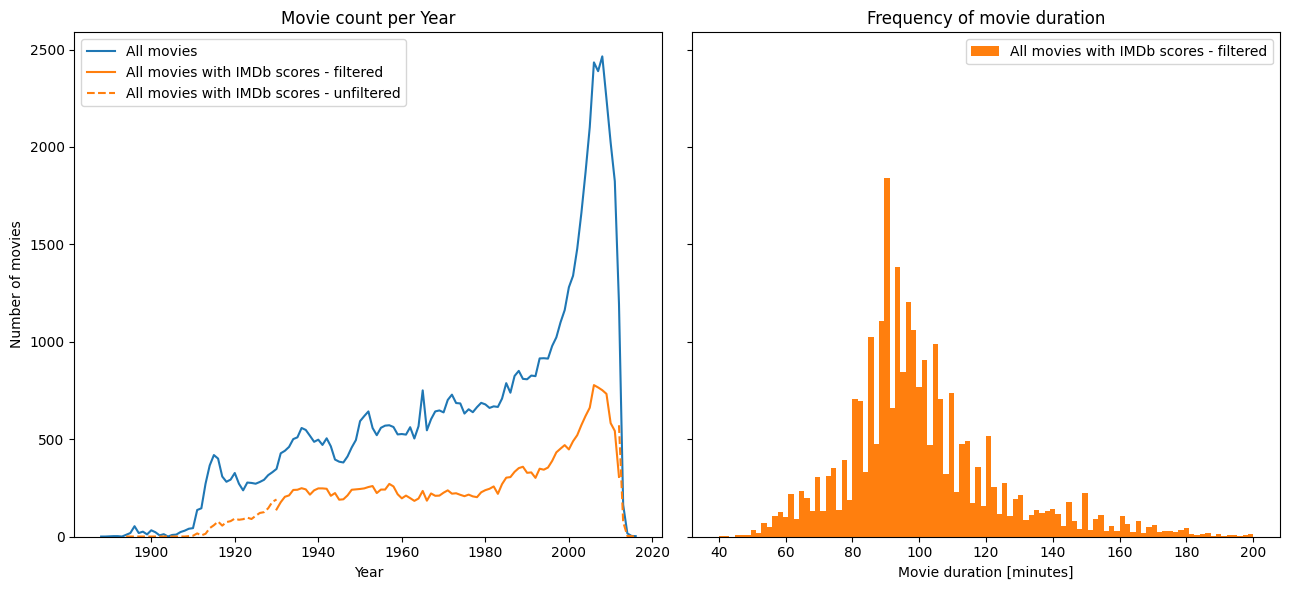

In [63]:
# Get unfiltered movies with IMDb scores -> Selecting years that will not be plotted with the filtered data
movies_ufR = movies_uf.query('`Movie release date` >= @max_movie_year').copy()
movies_ufL = movies_uf.query('`Movie release date` <= @min_movie_year').copy()

# There is a movie with a typo in the original dataset, we can manually correct this 
meta_movie["Movie release date"][meta_movie["Movie release date"]==1010] = 2010

# Count all movies without merging with IMDb
all_movie_counts = meta_movie['Wikipedia movie ID'].groupby(meta_movie['Movie release date']).count()

# Count movies after merging with IMDb with and without filtering
movie_counts = movies['Wikipedia movie ID'].groupby(movies['Movie release date']).count()
movie_counts_ufL = movies_ufL['Wikipedia movie ID'].groupby(movies_ufL['Movie release date']).count()
movie_counts_ufR = movies_ufR['Wikipedia movie ID'].groupby(movies_ufR['Movie release date']).count()

#       ----- PLOT -----
fig, axes = plt.subplots(1, 2, figsize=(13, 6), sharey= True)

# subplot 1: plot the counts of all movies
axes[0].set_title('Movie count per Year')
axes[0].set_ylabel('Number of movies')
axes[0].set_xlabel('Year')
axes[0].plot(all_movie_counts.index, all_movie_counts.values, color= 'C0', label= 'All movies')
axes[0].plot(movie_counts.index, movie_counts.values, color= 'C1', label= 'All movies with IMDb scores - filtered')
axes[0].plot(movie_counts_ufL.index, movie_counts_ufL.values, color= 'C1', linestyle = '--',label= 'All movies with IMDb scores - unfiltered')
axes[0].plot(movie_counts_ufR.index, movie_counts_ufR.values, color= 'C1', linestyle = '--')
axes[0].legend(loc="upper left")

axes[1].set_title('Frequency of movie duration')
axes[1].set_xlabel('Movie duration [minutes]')
axes[1].hist(movies['Movie runtime'], bins = 100, color = 'C1', label= 'All movies with IMDb scores - filtered')
axes[1].legend(loc="upper right")

plt.tight_layout()
plt.show()

*Observation:* We have significantly reduced the number of films in our dataset. However, the distribution of drama movies is similar to the all movies with IMDb scores in both `Release date` and `Film duration`. We still have close to 15'000 drama movies to base our analysis on.

In [64]:
# Display descriptive statistics for selected columns in the 'movies' DataFrame:
# - 'Movie release date'
# - 'Movie box office revenue'
# - 'Movie runtime'
# - 'startYear'
# - 'averageRating'
# - 'numVotes'
movies[['Movie release date','Movie box office revenue','Movie runtime','startYear','averageRating','numVotes']].describe()

,Movie release date,Movie box office revenue,Movie runtime,startYear,averageRating,numVotes
count,25526.0,6.579000e+03,25526.000000,25526.000000,25526.000000,2.552600e+04
mean,1979.542623,5.325191e+07,100.341616,1979.542623,6.100415,2.295320e+04
std,24.909427,1.169249e+08,22.987747,24.909427,1.055797,9.529364e+04
min,1930.0,1.140800e+04,40.000000,1930.000000,1.100000,5.000000e+01
25%,1957.0,2.500000e+06,87.000000,1957.000000,5.500000,3.590000e+02
50%,1986.0,1.327211e+07,96.000000,1986.000000,6.200000,1.372500e+03
75%,2002.0,4.923197e+07,110.000000,2002.000000,6.800000,7.005250e+03
max,2012.0,2.782275e+09,200.000000,2012.000000,9.500000,2.816055e+06


Now lets work on the **movie genres**, we can use the fact that they are a dictionary to have a look at their frequency

## 3.2 Dataframe 2: Actors

In [65]:
actors

,IMDb_ID,IMDb_actor_ID,ordering,Wikipedia movie ID,Movie name,Movie release date,primaryName,actor_connections,awards,nominations,movie_count,genre_diversity,is_male,age_at_release
0,tt0228333,nm0000449,1,975900,Ghosts of Mars,2001,Natasha Henstridge,1.011133e-03,0,0,8,20,0,27
1,tt0251174,nm0000449,2,2195094,Kevin of the North,2001,Natasha Henstridge,1.011133e-03,0,0,9,20,0,27
2,tt0115471,nm0000449,2,9340076,Adrenalin: Fear the Rush,1996,Natasha Henstridge,1.513130e-04,0,0,2,9,0,22
3,tt0117011,nm0000449,2,4163034,Maximum Risk,1996,Natasha Henstridge,1.513130e-04,0,0,3,9,0,22
4,tt0114508,nm0000449,1,689763,Species,1995,Natasha Henstridge,7.602365e-05,0,0,1,6,0,21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75972,tt1606259,nm4774361,2,34980460,Knuckle,2011,Paddy Quinn McDonagh,1.310674e-30,0,0,1,1,<NA>,<NA>
75973,tt1606259,nm4774484,3,34980460,Knuckle,2011,Michael Quinn McDonagh,1.310674e-30,0,0,1,1,<NA>,<NA>
75974,tt0362411,nm0514648,1,9971909,Another Nice Mess,1972,Rich Little,3.250269e-16,0,0,1,1,1,34
75975,tt0362411,nm0901343,2,9971909,Another Nice Mess,1972,Herb Voland,3.250269e-16,0,0,1,1,1,54


In [66]:
# Count the number of unique IMDb actor IDs in the 'actors' DataFrame.
unique_actors = len(actors['IMDb_actor_ID'].unique())

print('There are {} unique actors out of {} entries. A actor plays on average in {} films' .format(unique_actors, len(actors.index),len(actors.index)/unique_actors))

There are 26923 unique actors out of 75977 entries. A actor plays on average in 2.8220109200312002 films


This shows that there is a good range of actors in our dataset (i.e we don't have a large amount of different actors).

In [67]:
# Display a random sample of 5 rows from the 'actors' DataFrame.
actors.sample(5)

,IMDb_ID,IMDb_actor_ID,ordering,Wikipedia movie ID,Movie name,Movie release date,primaryName,actor_connections,awards,nominations,movie_count,genre_diversity,is_male,age_at_release
62798,tt0091387,nm0741642,2,30971426,Last Resort,1986,Robin Pearson Rose,0.000129,0,0,1,1,0,<NA>
23742,tt0067634,nm0765546,1,22884413,The Pursuit of Happiness,1971,Michael Sarrazin,0.003383,0,0,7,13,1,31
27804,tt0041994,nm0000784,3,5134517,Tulsa,1949,Pedro Armendáriz,0.010182,0,0,6,10,1,37
2672,tt0030019,nm0694090,1,19569381,Cowboy from Brooklyn,1938,Dick Powell,0.071073,0,0,18,34,1,34
48501,tt0107091,nm0001301,2,4511738,Heart and Souls,1993,Charles Grodin,0.005998,0,0,17,1,1,58


In [68]:
# Display descriptive statistics for selected columns in the 'actors' DataFrame:
# - 'Movie release date'
# - 'awards'
# - 'nominations'
actors[['Movie release date','awards','nominations', 'movie_count', 'genre_diversity', 'is_male', 'age_at_release']].describe()

,Movie release date,awards,nominations,movie_count,genre_diversity,is_male,age_at_release
count,75977.0,75977.000000,75977.000000,75977.000000,75977.000000,65234.0,68571.0
mean,1979.441844,0.051634,0.232412,6.792174,10.110876,0.642901,37.359948
std,24.919358,0.254072,0.840904,9.421823,14.044384,0.479148,12.70815
min,1930.0,0.000000,0.000000,1.000000,1.000000,0.0,0.0
25%,1957.0,0.000000,0.000000,1.000000,1.000000,0.0,28.0
50%,1986.0,0.000000,0.000000,3.000000,1.000000,1.0,35.0
75%,2002.0,0.000000,0.000000,9.000000,16.000000,1.0,45.0
max,2012.0,4.000000,17.000000,127.000000,97.000000,1.0,98.0


*Observation:* We can see that, on average, an actor has less than 0.05 Oscars, which may be an important factor if there is a correlation with the frequency of an actor's selection

# 4 Diving into the Research questions

In [69]:
actors.set_index(['IMDb_ID','IMDb_actor_ID'], inplace=True)
movies = movies.set_index('IMDb_ID')
movies_actors_merge = actors.merge(movies['averageRating'],left_on='IMDb_ID', right_index=True)

In [70]:
# Input:
#   - year (int)
#   - range (int)
# Output:
#   - Range (str)
def create_range(year, range=10):
    start_range = (year // range) * range
    return "{} - {}".format(start_range, start_range + range)


movies_actors_merge = movies_actors_merge.sort_values(by='Movie release date')
movies_actors_merge['ReleaseYearRange'] = movies_actors_merge['Movie release date'].apply(lambda x: create_range(x))

# Checkpoint 
##########################################################################################

In [71]:
# Pickle data to use later
actors.to_pickle("./data/actors.pkl")
movies.to_pickle("./data/movies.pkl")
movies_actors_merge.to_pickle("./data/movies_actors_merge.pkl")

In [4]:
movies_actors_merge = pd.read_pickle("./data/movies_actors_merge.pkl")

##########################################################################################

In [9]:
# Calculate the 30th and 70th percentiles
low_threshold = movies_actors_merge['averageRating'].quantile(0.45)
high_threshold = movies_actors_merge['averageRating'].quantile(0.55)

# Filter the DataFrame to keep only the rows in the lowest 30% and highest 30%
movies_actors_reduced = movies_actors_merge[(movies_actors_merge['averageRating'] <= low_threshold) | (movies_actors_merge['averageRating'] >= high_threshold)].copy()
movies_actors_reduced['is_good'] = movies_actors_reduced['averageRating']> 6
movies_actors_reduced['has_award']= movies_actors_reduced['awards'] > 0
movies_actors_reduced['has_nomination'] = movies_actors_reduced['nominations'] > 0 

## First analysis using t-test

In [10]:
# TODO

## Visualizing the evolution of features over time

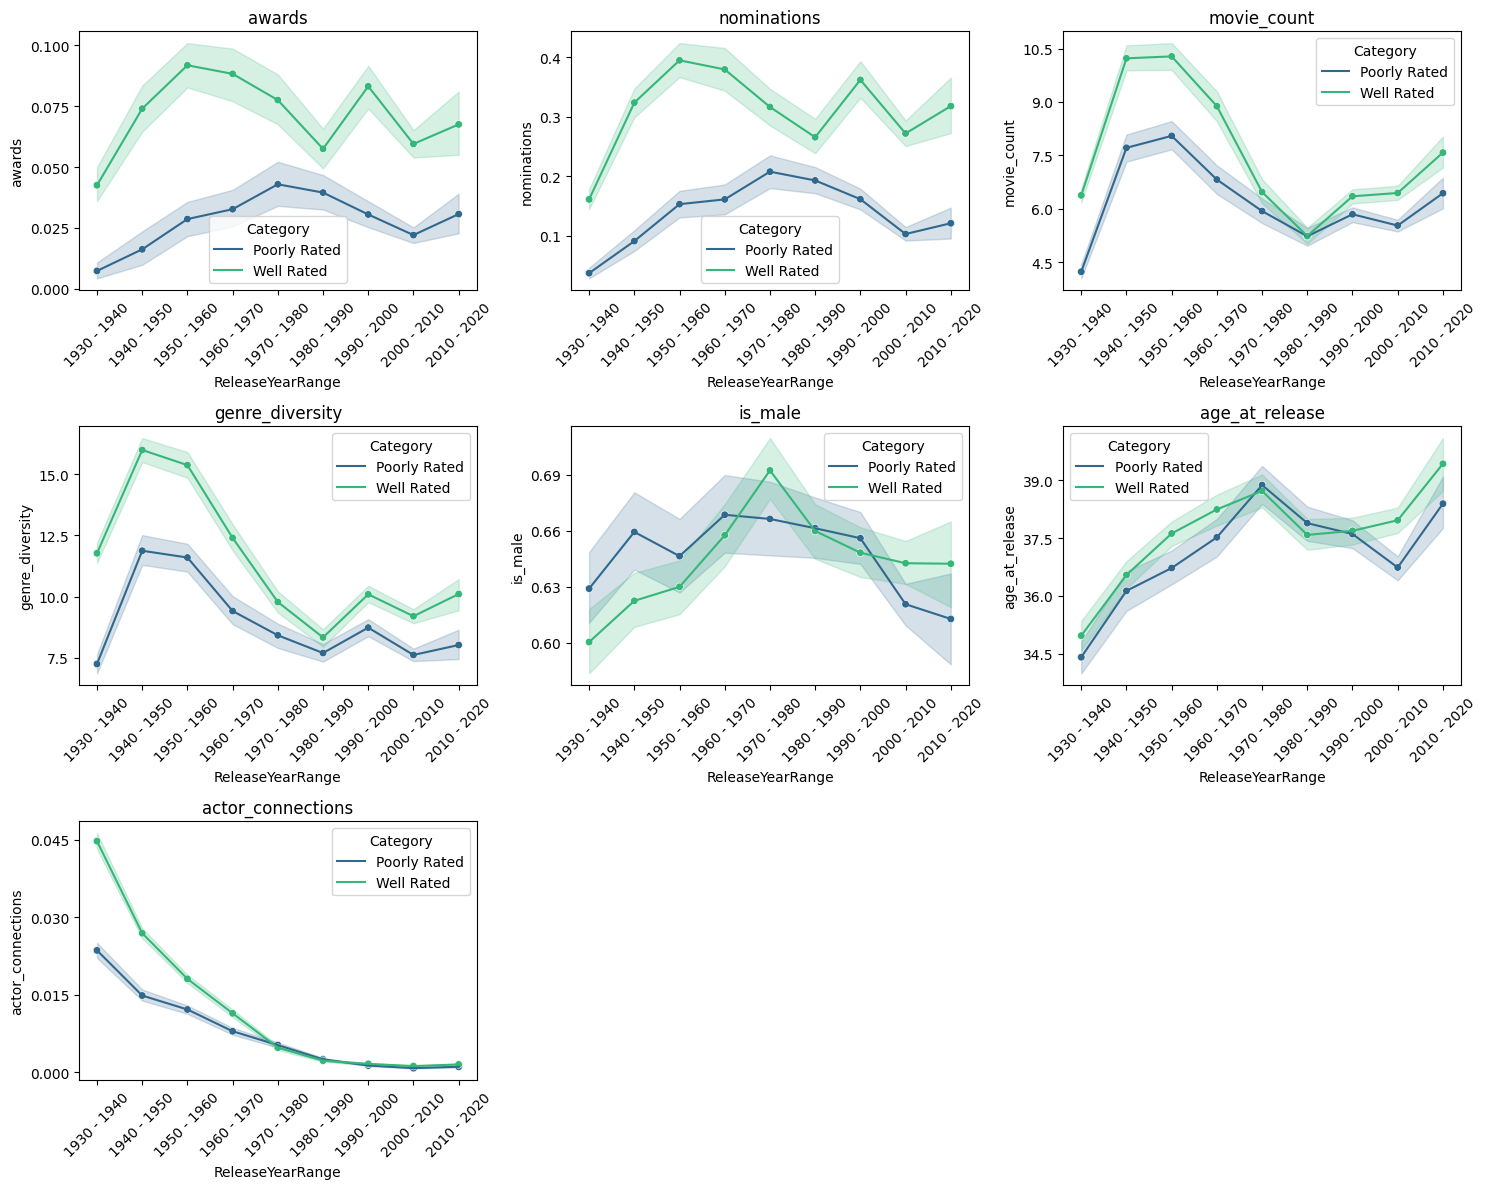

In [11]:
def do_fancy_ecpi_cute_plot(df, cat, diff, x, y_list, titles, ncols=3, max_y_ticks=5):

    nrows = -(-len(y_list) // ncols)

    fig, axes = plt.subplots(nrows, ncols, figsize=(5 * ncols, 4 * nrows))

    lo = df.query(f'{diff} < @{cat}').copy()
    hi = df.query(f'{diff} >= @{cat}').copy()
    # me = df.copy()
    
    lo.loc[:, 'Category'] = 'Poorly Rated'
    hi.loc[:, 'Category'] = 'Well Rated'
    # me.loc[:, 'Category'] = 'mean'

    for i, (y, title) in enumerate(zip(y_list, titles)):

        lo_filtered = lo[lo[y].notna()]
        hi_filtered = hi[hi[y].notna()]
        # me_filtered = me[me[y].notna()]

        lo_filtered.loc[:, y] = pd.to_numeric(lo_filtered[y])
        hi_filtered.loc[:, y] = pd.to_numeric(hi_filtered[y])
        # me_filtered.loc[:, y] = pd.to_numeric(me_filtered[y])
        
        lo_filtered_mean = lo_filtered.groupby(x)[y].mean().reset_index()
        lo_filtered_mean['Category'] = 'bellow {}'.format(globals()[cat])

        hi_filtered_mean = hi_filtered.groupby(x)[y].mean().reset_index()
        hi_filtered_mean['Category'] = 'above {}'.format(globals()[cat])

        # me_filtered_mean = me_filtered.groupby(x)[y].mean().reset_index()
        # me_filtered_mean['Category'] = 'mean'

        # frame = pd.concat([lo_filtered, hi_filtered, me_filtered])
        frame = pd.concat([lo_filtered, hi_filtered])

        # frame_mean = pd.concat([lo_filtered_mean, hi_filtered_mean, me_filtered_mean])
        frame_mean = pd.concat([lo_filtered_mean, hi_filtered_mean])
    
        ax = axes[i // ncols, i % ncols]
        sns.lineplot(data=frame, x=x, y=y, hue='Category', errorbar='ci', palette='viridis', ax=ax)
        sns.scatterplot(data=frame_mean, x=x, y=y, hue='Category', palette='viridis', ax=ax, legend=False, marker='o', s=30)
        ax.set_title(title)
        ax.legend(title='Category')

        # Rotate x-axis labels
        for label in ax.get_xticklabels():
            label.set_rotation(45)

        # Set y-axis tick frequency
        ax.yaxis.set_major_locator(MaxNLocator(nbins=max_y_ticks))
    

    # Turn off any unused subplots
    for j in range(i + 1, nrows * ncols):
        axes[j // ncols, j % ncols].axis('off')

    plt.tight_layout()
    plt.show()

mean_rating = round(movies_actors_reduced['averageRating'].mean(), 2)
do_fancy_ecpi_cute_plot(movies_actors_reduced, 'mean_rating', 'averageRating', 'ReleaseYearRange', 
                        ['awards', 'nominations', 'movie_count', 'genre_diversity', 'is_male', 'age_at_release', 'actor_connections'], 
                        ['awards', 'nominations', 'movie_count', 'genre_diversity', 'is_male', 'age_at_release', 'actor_connections'])

- Awards: Actors in movies rated above 6.03 tend to have accumulated more awards across the years compared to those in movies with ratings below 6.03.

- Nominations: Similarly, actors in higher-rated movies have received more nominations over the years.

- Movie Count: Actors in higher-rated movies have appeared in a greater number of movies, especially in the time frame from the 1940s to the early 2000s.

- Genre diversity (genre_diversity): Actors in higher-rated movies have tended to play in a greater variety of genres before their current movie, with the difference being most pronounced in the early release years.

- is_male (Gender Distribution): The proportion of male actors varies with time, and there's a higher proportion of male actors in movies above the 6.03 rating threshold in certain time periods. However, the overlapping confidence intervals suggest a significant variance in the data.

- Age at Release: Actors in higher-rated movies are generally older, particularly noticeable from the 1980s onward, whereas in earlier decades, the trend is not as distinct.

The plots suggest there are observable differences in the features of actors between high and low-rated movies. Specifically, actors in higher-rated movies have a history of more awards and nominations, have appeared in more movies, have had experience across a wider range of genres before the current movie, and are typically older at the time of the movie's release. The gender distribution is somewhat variable and does not show as clear a trend. These findings indicate that actors' experience and recognition (in terms of awards and variety of roles) may correlate with the ratings of the movies they are in.

## Awards X Average Ratings

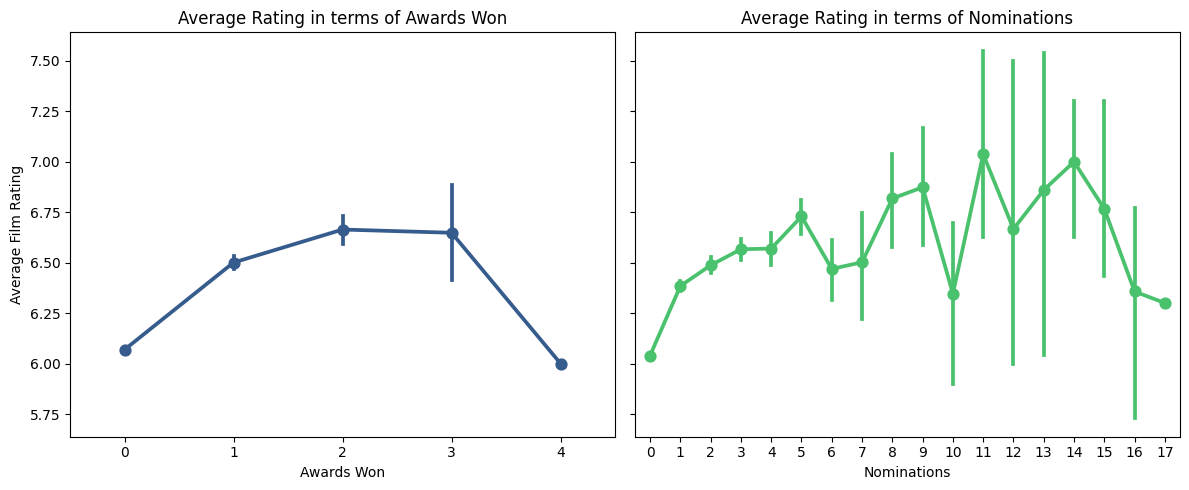

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# Plot 1
plt.subplot(1, 2, 1)
sns.pointplot(x='awards', y='averageRating', data=movies_actors_reduced, errorbar=('ci', 95), color=sns.color_palette('viridis')[1])
plt.title("Average Rating in terms of Awards Won")
plt.xlabel("Awards Won")
plt.ylabel("Average Film Rating")

# Plot 2
plt.subplot(1, 2, 2)
sns.pointplot(x='nominations', y='averageRating', data=movies_actors_reduced, errorbar=('ci', 95), color=sns.color_palette('viridis')[4])
plt.title("Average Rating in terms of Nominations")
plt.xlabel("Nominations")

plt.tight_layout()
plt.show()

[]

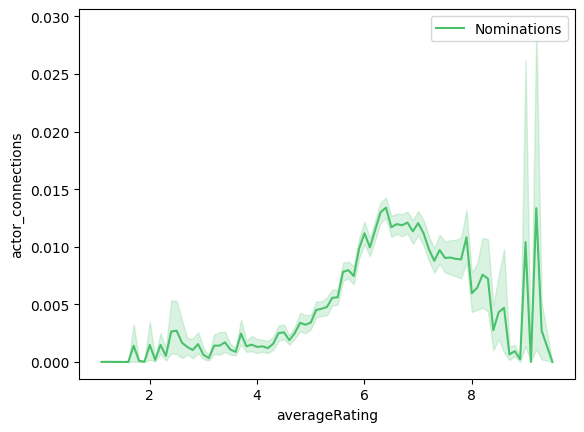

In [13]:
sns.lineplot(x='averageRating', y='actor_connections', data=movies_actors_reduced, errorbar=('ci', 95), label='Nominations',color=sns.color_palette('viridis')[4])
plt.plot()

These two plots show that there is indeed a significant difference in movie ratings in terms of oscars won and nominations recieved. In other words, actors with oscars and nominations generelly play in better rated films. 

On the nominations plot, the confidence interval explodes after 6 nominations due to little data, however before that we can see an significant incresing trend before that.

Another interesting observation is that we can we can distinguish films with and without awards, as having more than one award is not statistical significant.

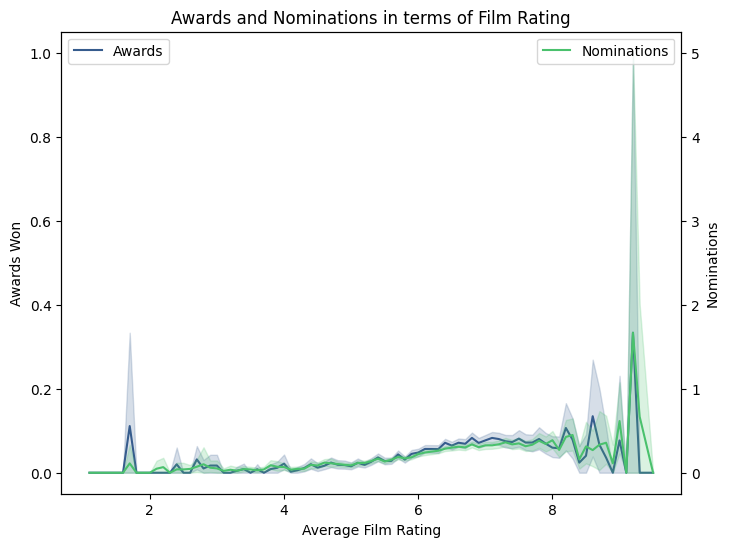

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you have already calculated and filtered 'actors_movies' DataFrame

# Create a figure and axis
fig, ax1 = plt.subplots(figsize=(8, 6))

# Plot on the first y-axis
sns.lineplot(x='averageRating', y='awards', data=movies_actors_reduced, errorbar=('ci', 95), ax=ax1, label='Awards', color=sns.color_palette('viridis')[1])
ax1.set_xlabel("Average Film Rating")
ax1.set_ylabel("Awards Won")

# Create a second y-axis and plot on it
ax2 = ax1.twinx()
sns.lineplot(x='averageRating', y='nominations', data=movies_actors_reduced, errorbar=('ci', 95), ax=ax2, label='Nominations',color=sns.color_palette('viridis')[4])
ax2.set_ylabel("Nominations")

# Display legends for both lines
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Adjust layout
plt.title("Awards and Nominations in terms of Film Rating")
plt.show()

An other way of looking at this data is plotting the average awards won/nominations per rating, shown in the plot above.As mentionned before, we can see the correlations between these two plots. We can alsoobserve a steady rise in awards won and nominations as the raiting increases meaning that films with high ratings generally have more oscars and nominations. Unfortunalty, we don't have enough data in the higher film ratings, hence the high confidence interval.

## Feature Correlation

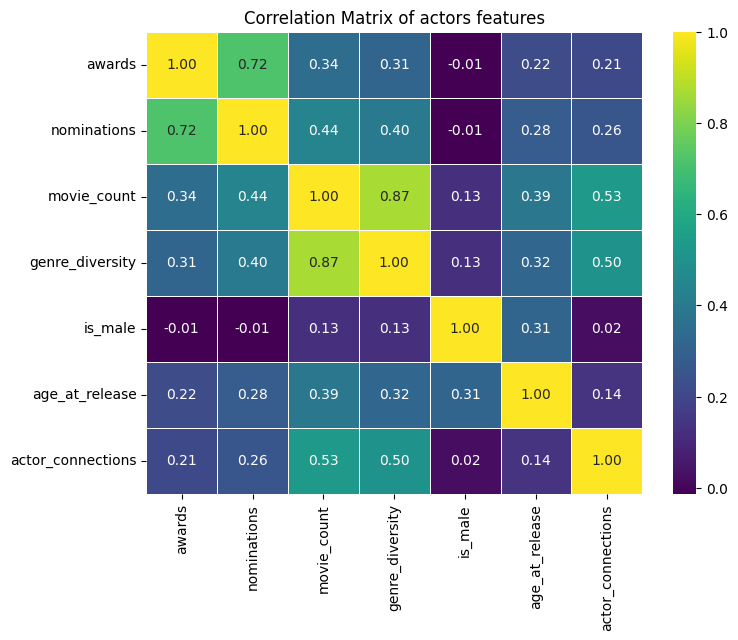

In [15]:
# - Correlation Emeline (Emeline)
#     - Correspond avec graph dimi mais en term de correlation

# Calculate the correlation matrix
correlation_matrix = movies_actors_reduced[['awards', 'nominations', 'movie_count', 'genre_diversity', 'is_male', 'age_at_release', 'actor_connections']].corr()

# Set up the matplotlib figure
plt.figure(figsize=(8, 6))

# Plot the heatmap
sns.heatmap(correlation_matrix, annot=True, cmap="viridis", fmt=".2f", linewidths=.5)

plt.title('Correlation Matrix of actors features')
plt.show()

## Correlation Features with Ratings

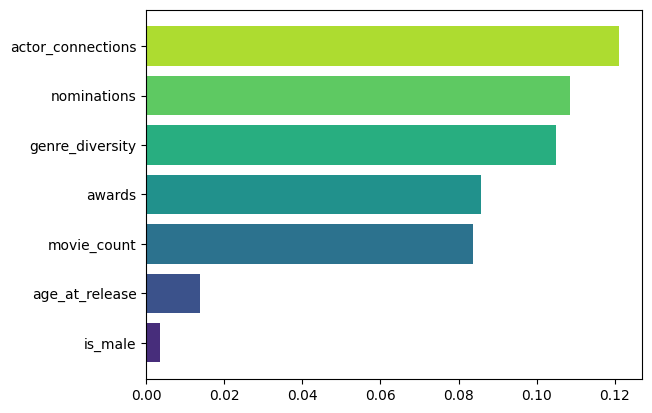

In [16]:
correlation_matrix=movies_actors_reduced[[ 'awards', 'nominations', 'movie_count', 'genre_diversity', 'is_male', 'age_at_release','averageRating', 'actor_connections']].corr()
correlation_with_X = correlation_matrix['averageRating'].drop('averageRating')  # Remove correlation with itself
correlation_with_X_sorted = correlation_with_X.sort_values()
# Create a horizontal bar plot
plt.barh(correlation_with_X_sorted.index, correlation_with_X_sorted, color=sns.color_palette('viridis', n_colors=len(correlation_with_X_sorted)))
plt.show()

Here we can see that nominations, genres_b4 and awards are the 3 features with the highest correlation with the movie rating

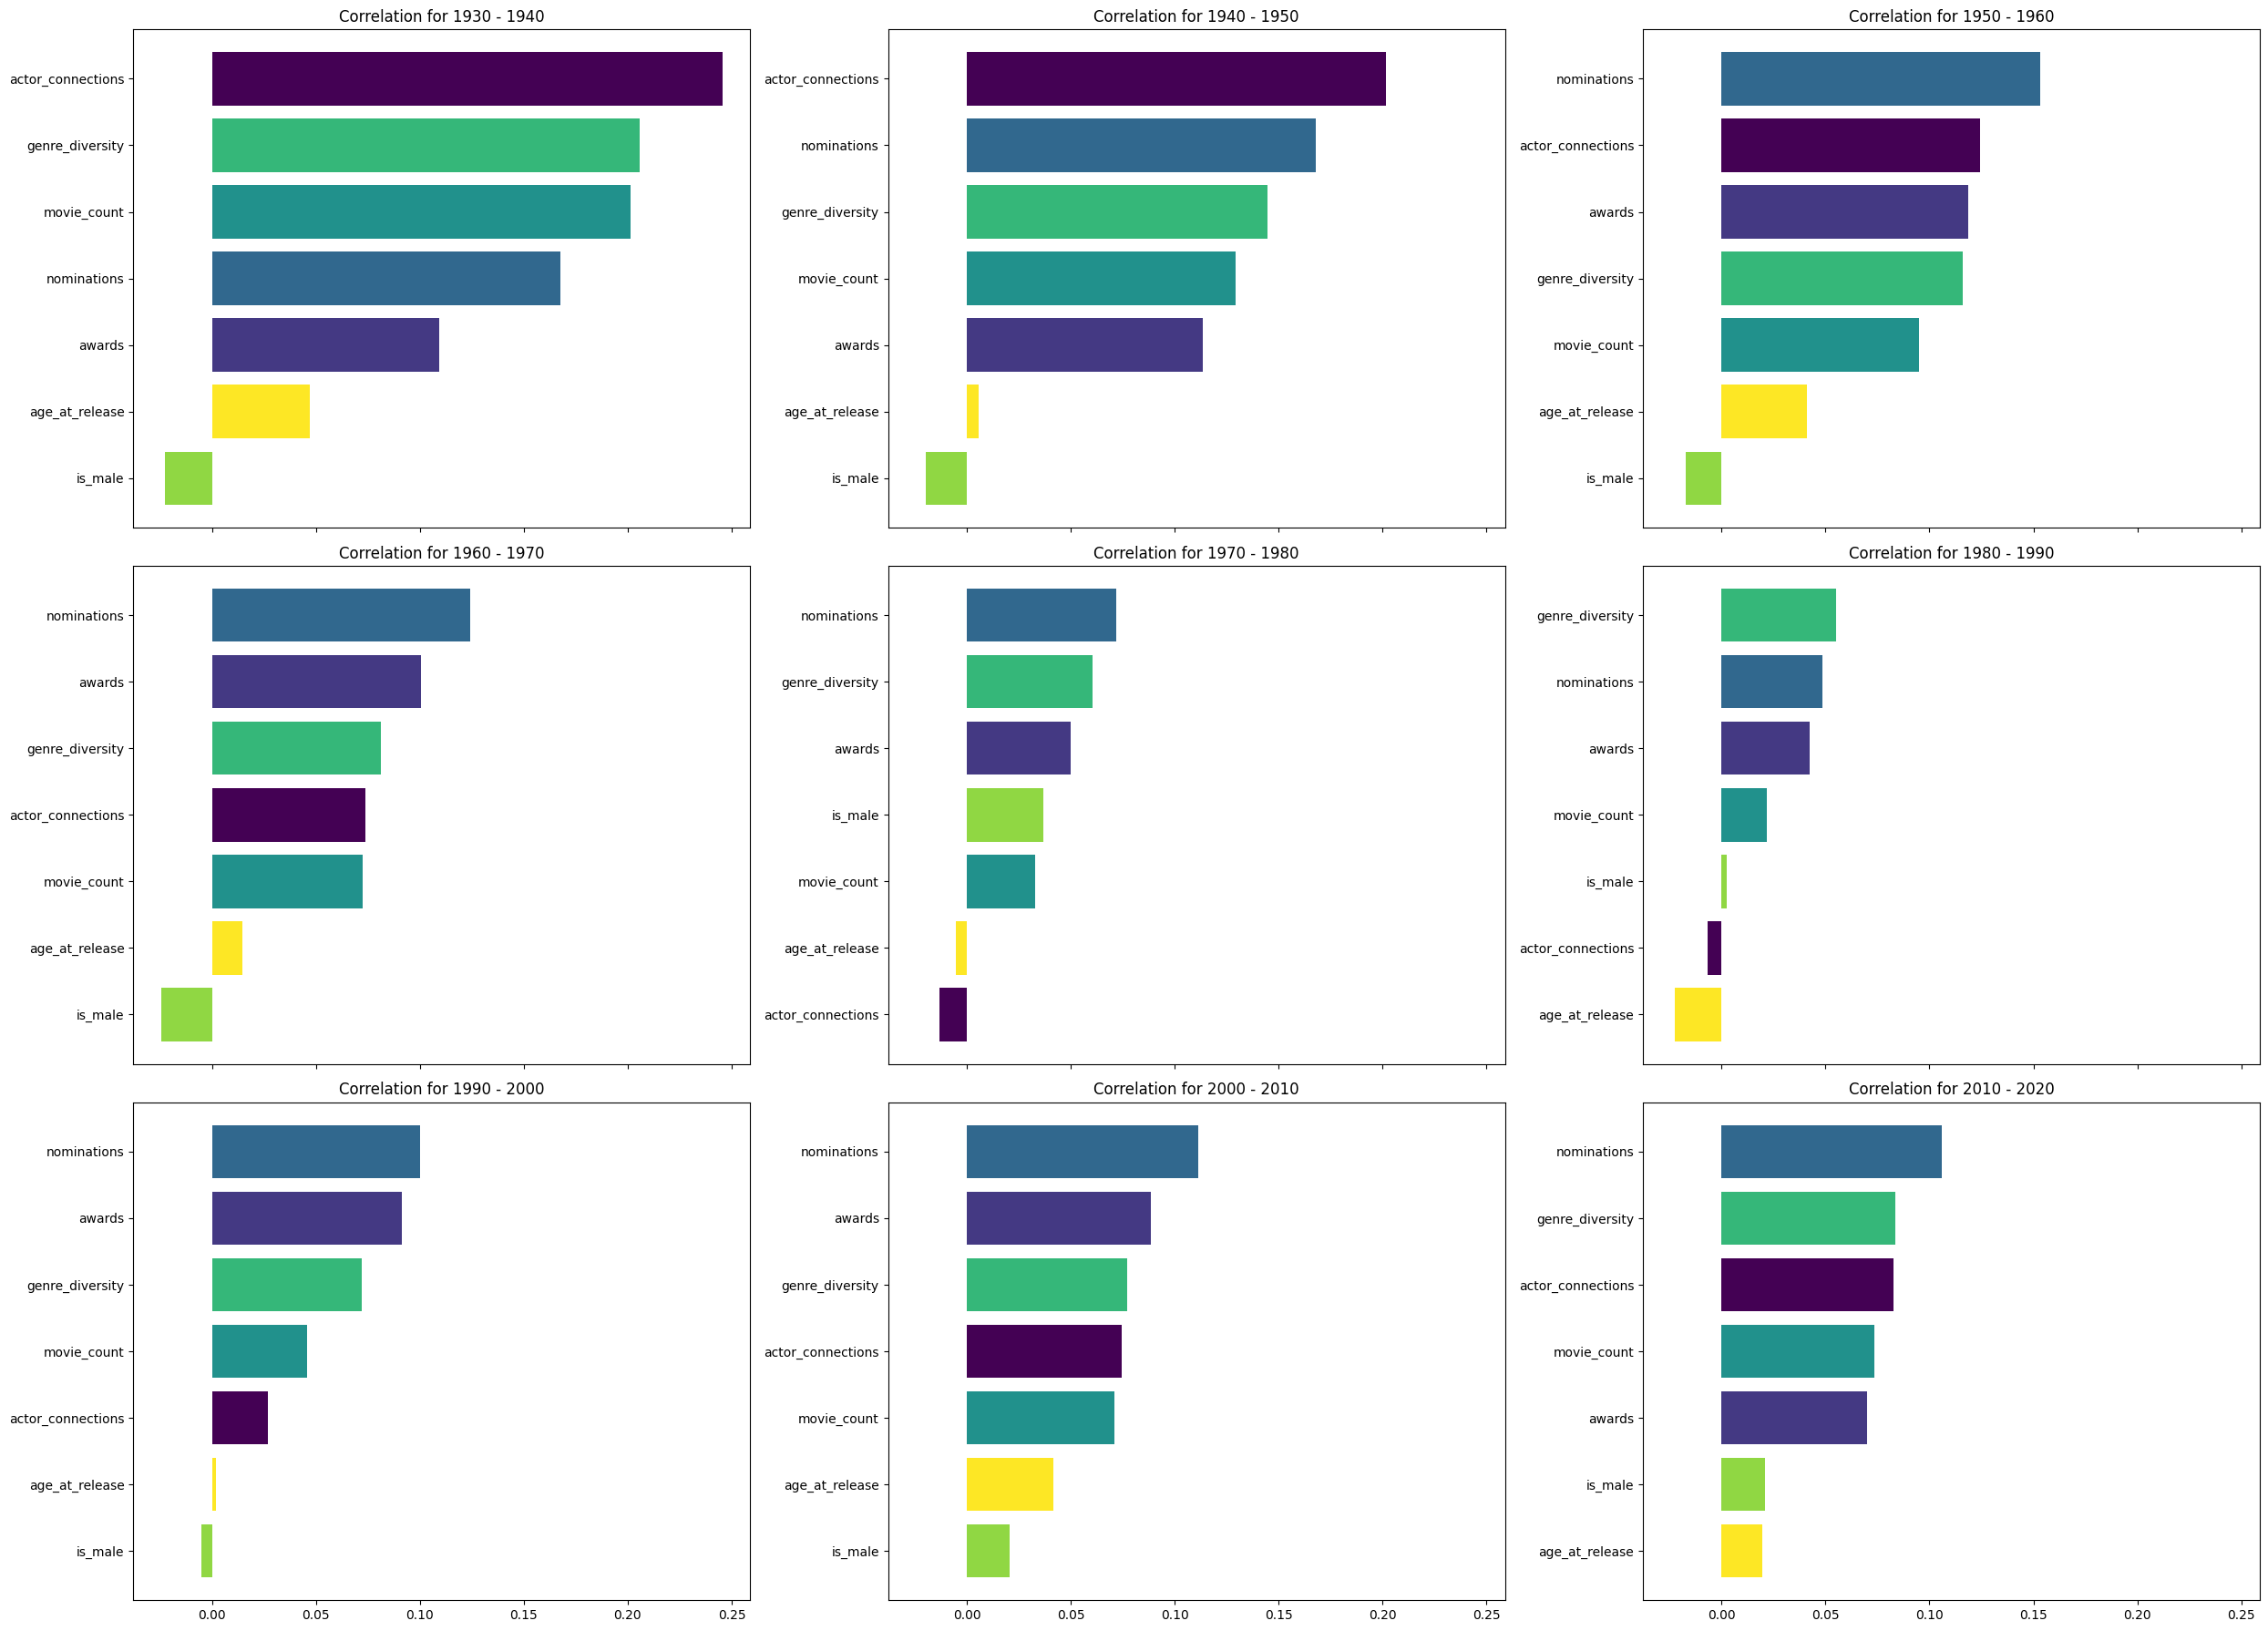

In [17]:
figs, axs = plt.subplots(3, 3, figsize=(25, 18), sharex= True)
axs = axs.flatten()
Years = movies_actors_reduced['ReleaseYearRange'].unique()

# Define a colormap
cmap = plt.cm.viridis

# List of features
features = [ 'actor_connections','awards', 'nominations', 'movie_count', 'genre_diversity', 'is_male', 'age_at_release']

# Map each feature to a numerical value
feature_values = np.linspace(0, 1, len(features))
feature_colors = {feature: cmap(value) for feature, value in zip(features, feature_values)}

for i, year_range in enumerate(Years):
    Year = movies_actors_reduced[movies_actors_reduced['ReleaseYearRange'] == year_range]
    
    # Reset the index of Year to ensure alignment
    Year.reset_index(drop=True, inplace=True)

    correlation_matrix = Year[features + ['averageRating']].corr()
    correlation_with_X = correlation_matrix['averageRating'].drop('averageRating')
    correlation_with_X_sorted = correlation_with_X.sort_values()

    # Get colors for each feature
    colors = [feature_colors[feature] for feature in correlation_with_X_sorted.index]

    # Create a horizontal bar plot with specified colors
    axs[i].barh(correlation_with_X_sorted.index, correlation_with_X_sorted, color=colors)
    axs[i].set_title(f'Correlation for {year_range}')

plt.tight_layout()
plt.show()

## Analysis with Matching

In [18]:
movies_actors_reduced['is_good_int'] = movies_actors_reduced['is_good'].apply(lambda x: 1 if x else 0)
fit = smf.logit('is_good_int ~ has_nomination', data=movies_actors_reduced).fit()
print(fit.summary())   

Optimization terminated successfully.
         Current function value: 0.680799
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:            is_good_int   No. Observations:                72493
Model:                          Logit   Df Residuals:                    72491
Method:                           MLE   Df Model:                            1
Date:                Thu, 21 Dec 2023   Pseudo R-squ.:                 0.01033
Time:                        14:42:42   Log-Likelihood:                -49353.
converged:                       True   LL-Null:                       -49868.
Covariance Type:            nonrobust   LLR p-value:                6.041e-226
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  0.1190      0.008     15.012      0.000       0.103      

In [90]:
# Create the treatment and control groups where treatment is having won at least one award
treatment = movies_actors_reduced[movies_actors_reduced['has_nomination'] == 1].dropna()
control = movies_actors_reduced[movies_actors_reduced['has_nomination'] == 0].dropna()

G = nx.Graph()

match_params = [('age_at_release', 3), ('genre_diversity', 5), ('has_award', 0), ("movie_count", 2), ("is_male", 0), ("actor_connections", 0.05)]

def check_match(treat_row, ctrl_row, match_params):
    for param, threshold in match_params:
        if abs(treat_row[param] - ctrl_row[param]) > threshold:
            return False
    return True

for treat_id, treat_row in treatment.iterrows():
    for ctrl_id, ctrl_row in control.iterrows():
        if check_match(treat_row, ctrl_row, match_params):
            G.add_edge(treat_id, ctrl_id)

matching = nx.max_weight_matching(G)
matched = [i[0] for i in matching] + [i[1] for i in matching]
balanced_df = movies_actors_reduced.loc[matched]

KeyboardInterrupt: 

In [96]:
fit = smf.logit('is_good_int ~ has_nomination', data=balanced_df).fit()
print(fit.summary())   

Optimization terminated successfully.
         Current function value: 0.545008
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:            is_good_int   No. Observations:                  948
Model:                          Logit   Df Residuals:                      946
Method:                           MLE   Df Model:                            1
Date:                Thu, 21 Dec 2023   Pseudo R-squ.:                 0.09501
Time:                        13:12:53   Log-Likelihood:                -516.67
converged:                       True   LL-Null:                       -570.91
Covariance Type:            nonrobust   LLR p-value:                 2.101e-25
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  0.2280      0.093      2.447      0.014       0.045      

## Analyse Actor connections

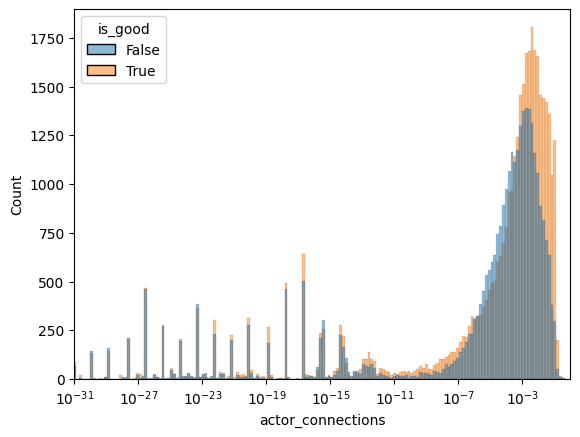

In [33]:
sns.histplot(data=movies_actors_reduced, x="actor_connections", hue = 'is_good', log_scale=(True, False))
plt.xlim(pow(10,-31) , 1)
plt.show()

In [22]:
from scipy.stats import mannwhitneyu

# Performing the Mann-Whitney U Test
mannwhitney = mannwhitneyu(movies_actors_reduced[movies_actors_reduced['is_good']== True]['actor_connections'], movies_actors_reduced[movies_actors_reduced['is_good']== False]['actor_connections'], alternative='two-sided')
print(mannwhitney)

MannwhitneyuResult(statistic=13867193.5, pvalue=2.467826106071644e-108)


## Analyse number of films

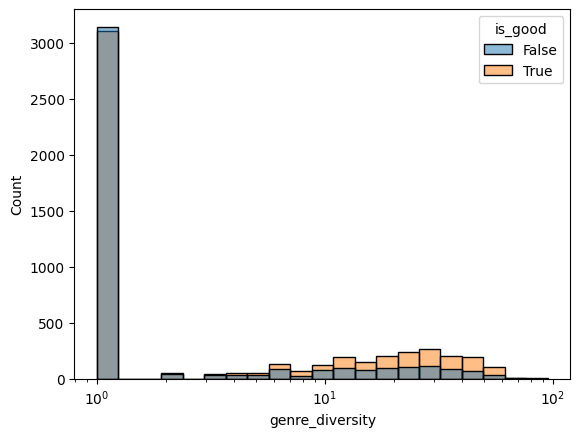

In [24]:
sns.histplot(data=movies_actors_reduced, x="genre_diversity", hue = 'is_good', log_scale=True)
plt.show()

In [26]:
# Performing the Mann-Whitney U Test
mannwhitney = mannwhitneyu(movies_actors_reduced[movies_actors_reduced['is_good']== True]['genre_diversity'], movies_actors_reduced[movies_actors_reduced['is_good']== False]['genre_diversity'], alternative='two-sided')
print(mannwhitney)

MannwhitneyuResult(statistic=12815190.5, pvalue=6.661746644724156e-63)


## PCA

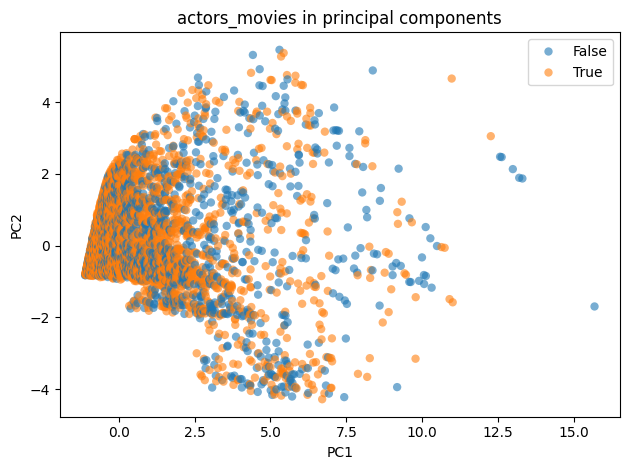

In [18]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming actors_movies is your original DataFrame

# Standardize the data
scaler = StandardScaler()
df_standardized = scaler.fit_transform(movies_actors_reduced[['Movie release date', 'has_nomination', 'has_award', 'movie_count', 'genre_diversity', 'actor_connections']].dropna())

# Perform PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(df_standardized)
df_pca = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])
df_pca['is_good'] = movies_actors_reduced.reset_index()['is_good']

# df_pca[['PC1','PC2']] = df_pca[['PC1','PC2']].round(1)


counts = df_pca.groupby(['PC1', 'PC2']).size().reset_index(name='Count')
counts['is_good'] = movies_actors_reduced.reset_index()['is_good']
# counts['threshhold'] = counts['Count']>0

sns.scatterplot(data=counts, x='PC1', y='PC2', hue='is_good', linewidth=0, sizes=(20, 1000), alpha= 0.6)

# Place the legend outside the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.title('actors_movies in principal components')
plt.legend()
plt.tight_layout()
plt.show()


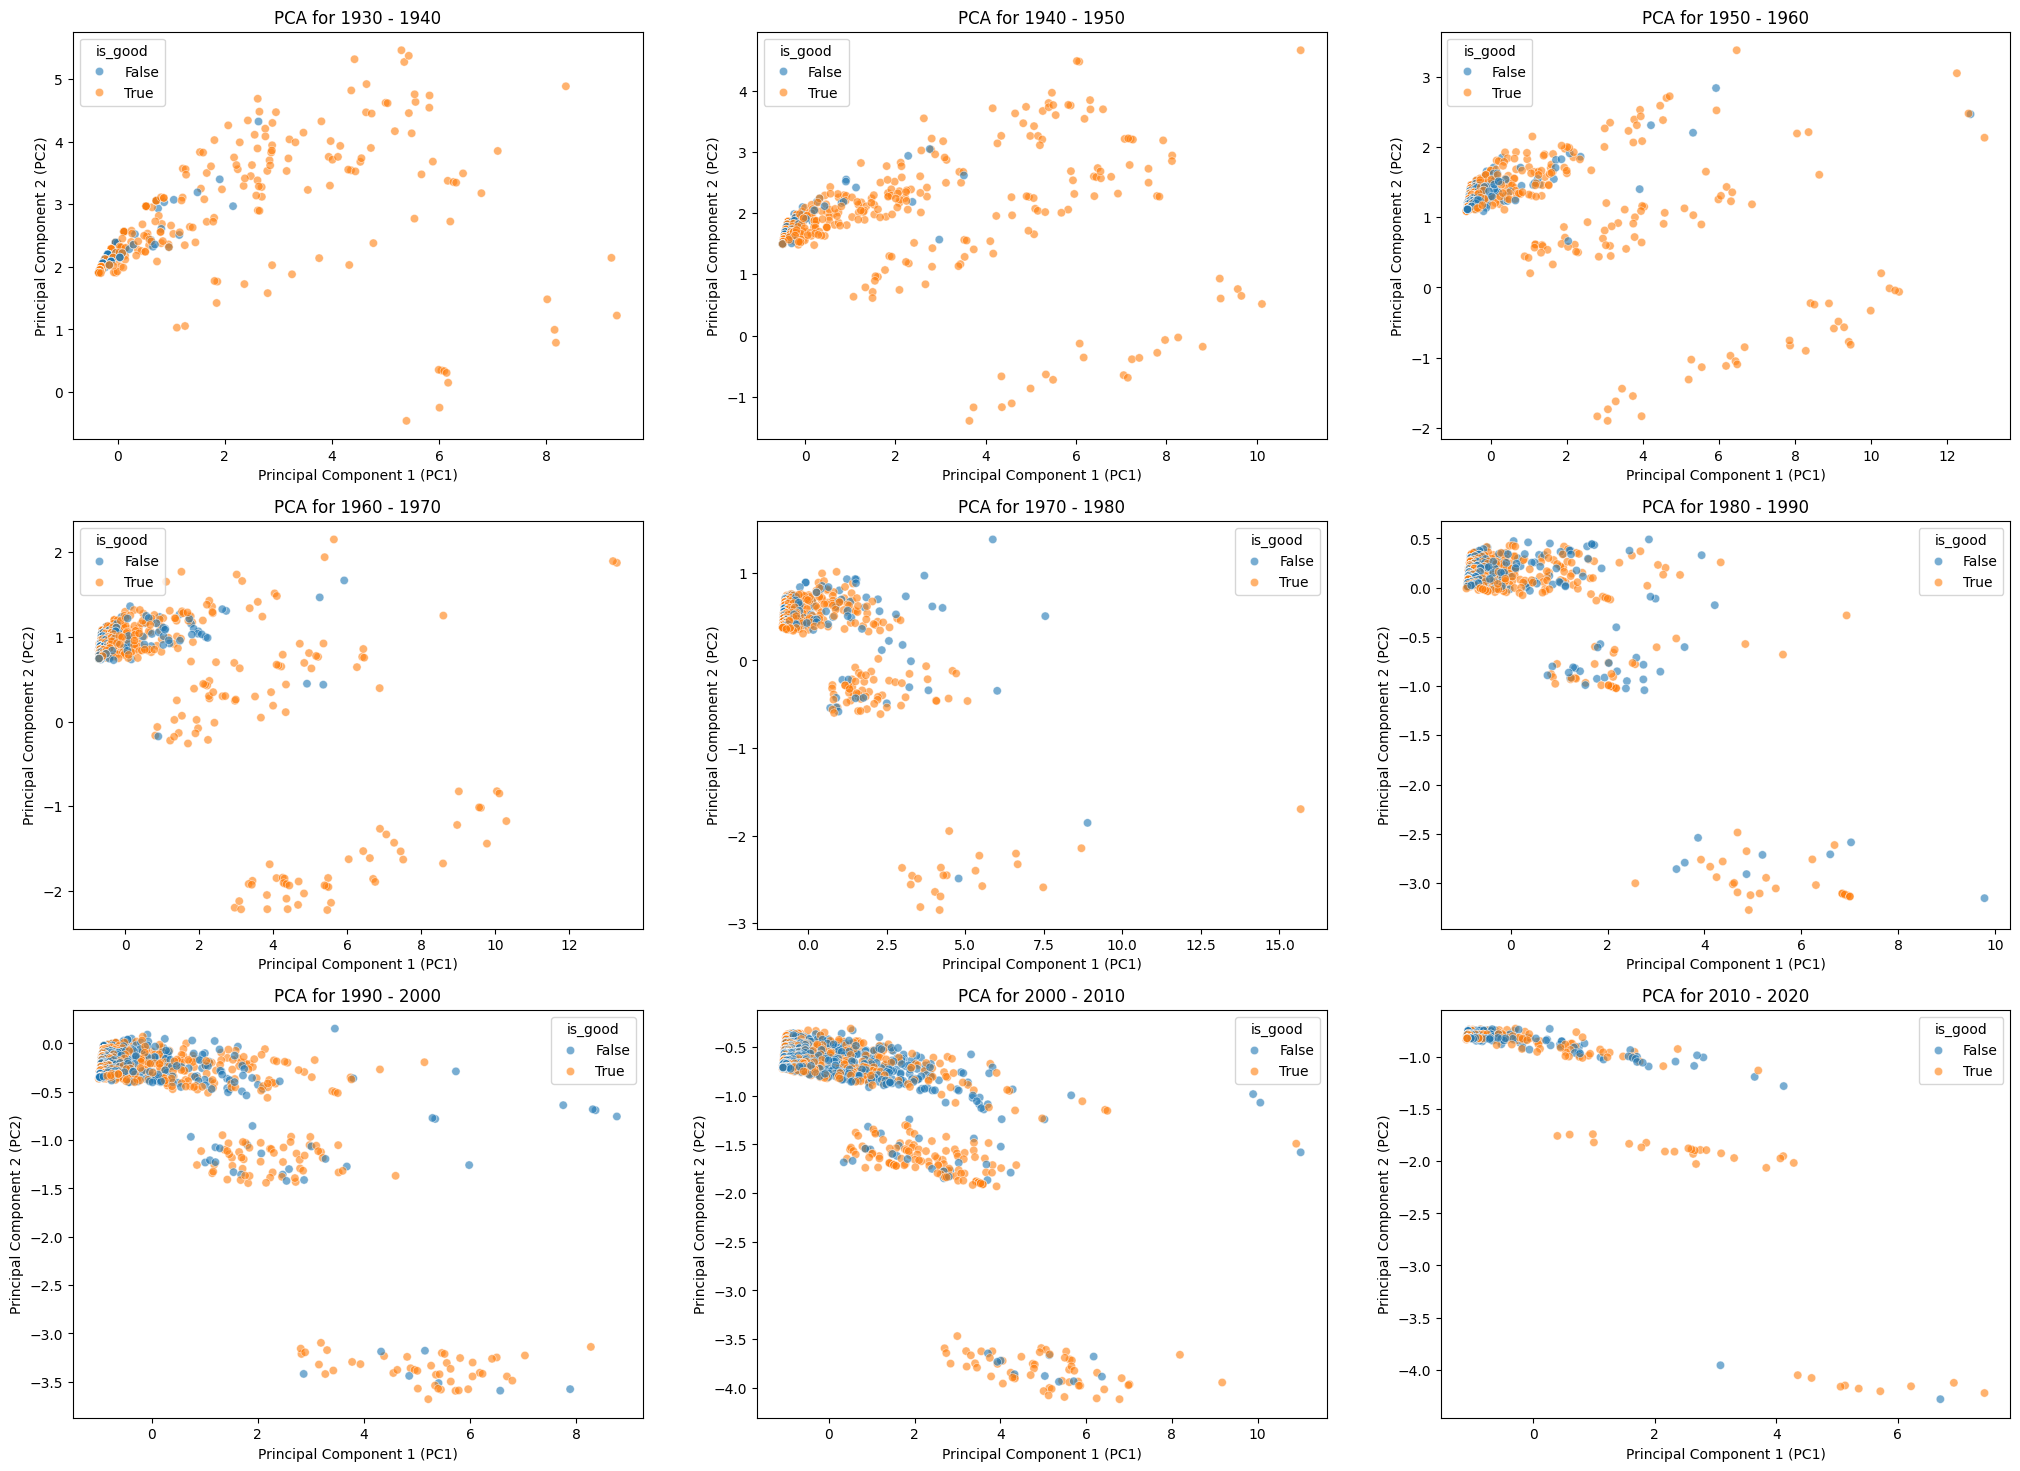

In [19]:
fig, axs = plt.subplots(3, 3, figsize=(25, 18))
axs = axs.flatten()
Years = movies_actors_reduced['ReleaseYearRange'].unique()
df_pca['year'] = movies_actors_reduced.reset_index()['ReleaseYearRange']

for i, year_range in enumerate(Years):
    sns.scatterplot(data=df_pca[df_pca['year'] == year_range], hue = 'is_good', x='PC1', y='PC2', alpha=0.6, ax=axs[i])

    axs[i].set_xlabel('Principal Component 1 (PC1)')
    axs[i].set_ylabel('Principal Component 2 (PC2)')
    axs[i].set_title(f'PCA for {year_range}')

plt.show()

## Machine Learning & Effectiveness of Prediction

In [ ]:
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import euclidean_distances
from sklearn.metrics import accuracy_score

In [ ]:

actors_movies_agg = movies_actors_reduced[['awards','nominations', 'genre_diversity','Movie release date', 'averageRating', 'actor_connections']].reset_index()
actors_movies_agg = actors_movies_agg.groupby('IMDb_ID').agg({'awards': 'sum', 'nominations': 'sum', 'genre_diversity': 'sum','Movie release date':'mean', 'averageRating':'mean', 'actor_connections':'mean' }).reset_index()

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Assuming you have already imported necessary libraries and defined X, y, and threshold

y = actors_movies_agg['averageRating'].to_numpy()
X = actors_movies_agg[['awards', 'nominations', 'genre_diversity', 'Movie release date', 'actor_connections']].to_numpy()
threshold = 6
y = y > threshold

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Create an instance of the DecisionTreeClassifier
classifier = DecisionTreeClassifier()

# Fit the classifier with training data
classifier.fit(X_train, y_train)

# Make predictions on the test set
y_predict = classifier.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_predict)
print("Accuracy:", accuracy)


Accuracy: 0.6056201550387597


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Preparing the data for logistic regression
# Converting 'is_good' to a numerical binary variable
movies_actors_reduced['is_good'] = movies_actors_reduced['is_good'].astype(int)

# Selecting the predictor and response variables
X = movies_actors_reduced[['actor_connections', 'genre_diversity', 'awards', 'movie_count']]
y = movies_actors_reduced['is_good']

X_train_ext, X_test_ext, y_train_ext, y_test_ext = train_test_split(X, y, test_size=0.3, random_state=42)

# Creating and training the Random Forest classifier with the extended feature set
rf_clf_ext = RandomForestClassifier(random_state=42)
rf_clf_ext.fit(X_train_ext, y_train_ext)

# Making predictions on the extended test set
y_pred_rf_ext = rf_clf_ext.predict(X_test_ext)

# Displaying the classification report and confusion matrix for the extended Random Forest model
classification_report_rf_ext_str = classification_report(y_test_ext, y_pred_rf_ext)
confusion_matrix_rf_ext_arr = confusion_matrix(y_test_ext, y_pred_rf_ext)

print(classification_report_rf_ext_str)
print(confusion_matrix_rf_ext_arr)

              precision    recall  f1-score   support

           0       0.57      0.61      0.59      1211
           1       0.69      0.65      0.67      1617

    accuracy                           0.63      2828
   macro avg       0.63      0.63      0.63      2828
weighted avg       0.64      0.63      0.63      2828

[[ 735  476]
 [ 564 1053]]


In [ ]:
from sklearn.model_selection import GridSearchCV

# Defining the parameter grid
param_grid = {
    'n_estimators': [100, 200],  # Number of trees in the forest
    'max_depth': [10, 20, None],  # Maximum depth of the tree
    'min_samples_split': [2, 5],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2]    # Minimum number of samples required to be at a leaf node
}

# Creating the Grid Search with Cross-Validation
rf_clf_gs = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(estimator=rf_clf_gs, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)

# Fitting the grid search to the data
grid_search.fit(X_train_ext, y_train_ext)

# Best parameters found
best_params = grid_search.best_params_
best_params

Fitting 3 folds for each of 24 candidates, totalling 72 fits


{'max_depth': 10,
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'n_estimators': 100}

In [ ]:
# Creating the RandomForestClassifier with the best parameters
rf_clf_optimized = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=1,
    random_state=42
)

# Training the model
rf_clf_optimized.fit(X_train_ext, y_train_ext)

# Making predictions and evaluating the model
y_pred_optimized = rf_clf_optimized.predict(X_test_ext)
evaluation_report = classification_report(y_test_ext, y_pred_optimized)

print(evaluation_report)

              precision    recall  f1-score   support

           0       0.59      0.59      0.59      1211
           1       0.69      0.69      0.69      1617

    accuracy                           0.65      2828
   macro avg       0.64      0.64      0.64      2828
weighted avg       0.65      0.65      0.65      2828



In [ ]:
import plotly.express as px

# Assuming rf_clf_optimized is your trained RandomForestClassifier
feature_importances = rf_clf_optimized.feature_importances_

# Creating a DataFrame for the feature importances
features_df = pd.DataFrame({'Feature': X_train_ext.columns, 'Importance': feature_importances})

# Sorting the DataFrame based on importance
features_df = features_df.sort_values(by='Importance', ascending=False)

# Creating the Plotly bar chart
fig = px.bar(features_df, x='Importance', y='Feature', orientation='h',
             title='Feature Importances in RandomForest Model',
             labels={'Feature': 'Feature', 'Importance': 'Importance Score'})

# Show the plot
fig.show()

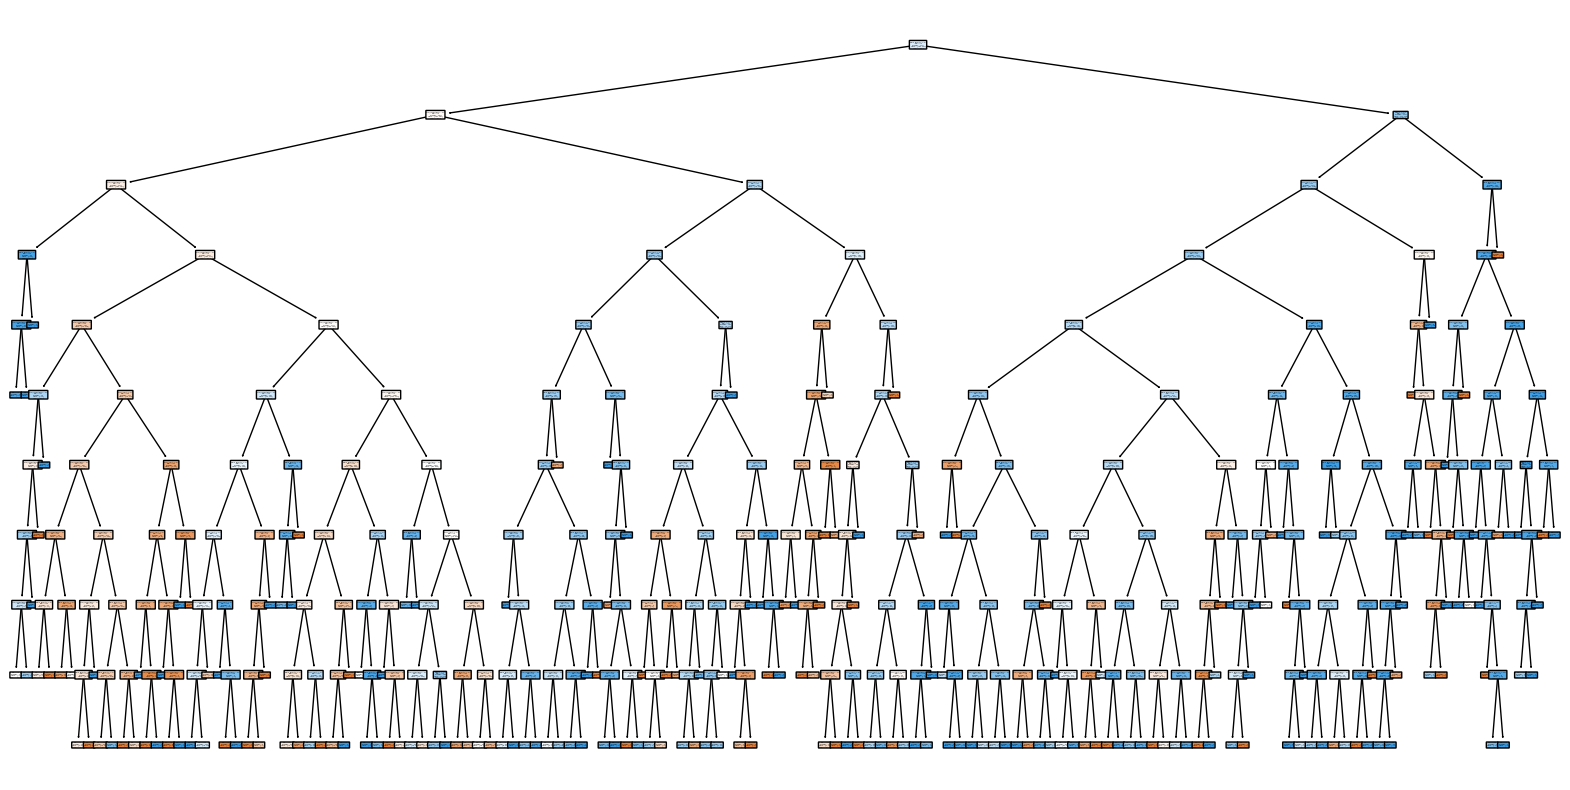

In [ ]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
from sklearn.ensemble import RandomForestClassifier

# Let's visualize the first tree in the forest
estimator = rf_clf_optimized.estimators_[0]

# Plotting the tree
plt.figure(figsize=(20, 10))  # Adjust the size as needed
plot_tree(estimator, 
          filled=True, 
          feature_names=X.columns, 
          class_names=['Class 0', 'Class 1'],
          rounded=True, 
          proportion=False, 
          precision=2)
plt.show()

## Conclusion and future work

In [ ]:
# Conclusion and future work